In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

src_path = os.path.abspath(os.path.join('../src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils.data import load_news, load_users
from utils.hydra import RunCollection
from evaluation.metrics import gs_score


In [2]:
DATA_DIR = "../data"
MIN_HISTORY_LENGTH = 3

In [3]:
runs = RunCollection.from_path("../outputs")
runs = runs.filter_by_job("train_embeddings")
run = runs.one()
run.show_config()

seed: 515
epochs: 10
embedding_dim: 100
batch_size: 128
learning_rate: 0.001
n_negative_samples: 4
data:
  seed: 468
  num_users: 200000
  source: large
  target: ${data.num_users}_${data.seed}
  mind_variant: ${data.target}



In [4]:
metrics = pd.read_csv(run.get_file_path("metrics.csv"))
metrics

,P@1,P@5,MRR,FMI,Silhouette,Train loss,epoch
0,0.000,0.000,0.073282,0.287594,0.297637,0.903918,0
1,0.000,0.500,0.172520,0.284227,0.413630,0.438126,1
2,0.000,0.500,0.209265,0.283156,0.444662,0.414427,2
3,0.125,0.750,0.339576,0.278538,0.455532,0.397396,3
4,0.000,0.625,0.219583,0.280536,0.457033,0.385194,4
5,0.000,0.500,0.203013,0.275973,0.463143,0.374783,5
6,0.000,0.500,0.196939,0.274677,0.446814,0.365187,6
7,0.000,0.500,0.193173,0.271252,0.438696,0.356269,7
8,0.000,0.500,0.173803,0.266217,0.423577,0.347888,8
9,0.000,0.375,0.167285,0.266011,0.419336,0.340088,9


In [5]:
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
topic_embeddings

Using topic embeddings from epoch 3


,subcategory,embedding
0,ads-latingrammys,"[-0.5279844, 1.2566609, 0.09642819, -0.2321693..."
1,ads-lung-health,"[0.07290848, -0.108872466, -0.116296835, 0.058..."
2,advice,"[-0.07572569, -0.05586439, -0.103811264, -0.10..."
3,animals,"[0.114049695, -0.09510901, -0.15006417, -0.116..."
4,autosbuying,"[0.012851537, 0.12294536, -0.030278068, 0.0524..."
...,...,...
249,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0...."
250,wellness,"[-0.018470695, -0.04485918, 0.08147979, -0.051..."
251,wines,"[-1.0180085, -0.6784834, -0.5070956, -0.352719..."
252,wonder,"[0.11814448, -0.012971732, -0.12646337, -0.029..."


In [6]:
mind_variant = run.config.data.mind_variant
news = load_news(mind_variant, columns=["category", "subcategory"], data_dir=DATA_DIR)
news = news.drop(columns="split")
news

,category,subcategory
id,,
N88753,lifestyle,lifestyleroyals
N23144,health,weightloss
N86255,health,medical
N93187,news,newsworld
N75236,health,voices
...,...,...
N29497,video,peopleandplaces
N55370,sports,football_nfl
N54303,sports,baseball_mlb


In [7]:
categories_in_news = set(news["subcategory"])
categories_in_embeddings = set(topic_embeddings["subcategory"])
missing_categories = categories_in_news.difference(categories_in_embeddings)
missing_categories = pd.DataFrame(missing_categories, columns=["subcategory"])
print("Missing categories:")
news\
    .merge(missing_categories, on="subcategory")\
    .groupby("subcategory")\
    .count()\
    .reset_index()\
    .rename(columns={"category": "n_articles"})

Missing categories:


,subcategory,n_articles
0,autoslosangeles,1
1,autosmidsize,1
2,basketball,1
3,cardio,1
4,causes-poverty,1
5,entertainmentmusic,1
6,entertainmenttv,1
7,finance-startinvesting,1
8,foodanddrink,1
9,halloween,1


In [8]:
news_with_embeddings = news.reset_index().merge(topic_embeddings, on="subcategory")
n_excluded_news = len(news) - len(news_with_embeddings)
news = news_with_embeddings
news = news.rename(columns={'embedding': 'topic_embedding'})
news = news.set_index("id")
news

,category,subcategory,topic_embedding
id,,,
N88753,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N81543,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N71593,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N33576,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N115791,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
...,...,...,...
N99911,autos,autosconvertibles,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,..."
N61853,sports,olympics-videos,"[-0.3969354, -0.6827047, -1.0807043, -0.829718..."
N70030,video,healthandfitness,"[-1.3226296, 0.03540926, -0.8963475, 1.3719544..."


In [9]:
users = load_users(mind_variant, data_dir=DATA_DIR)
users = users.drop(columns="split")
users

,history
user,
U224919,"[N69106, N87211, N71082, N47193, N13423, N4926..."
U674332,"[N67489, N58992, N127780, N25818, N116152, N75..."
U174429,"[N90578, N11210, N128909, N44451, N97475, N123..."
U337966,"[N107906, N113326, N16824, N125021, N31493, N2..."
U477175,"[N95287, N7154, N43428, N44660, N72579, N12649..."
...,...
U717179,"[N9375, N85428, N94639, N72571, N60165, N11636..."
U720817,"[N2232, N121551, N117814, N31538, N34374, N506..."
U720724,"[N7742, N88765, N102525, N92733, N3560, N12896..."


In [10]:
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
reading_history

,history,category,subcategory,topic_embedding
user,,,,
U224919,N69106,lifestyle,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
U527581,N69106,lifestyle,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
U71051,N69106,lifestyle,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
U711934,N69106,lifestyle,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
U405006,N69106,lifestyle,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
...,...,...,...,...
U721985,N128216,sports,more_sports,"[-0.049811807, 0.018902408, 0.020567032, 0.004..."
U721985,N14163,news,newsus,"[-0.035868783, -0.06469695, -0.064168714, -0.0..."
U721985,N81074,travel,travelarticle,"[-0.099426225, 0.076533645, -0.027644001, -0.1..."


In [11]:
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history["topic_embedding"].groupby("user")
users["gs"] = user_reads.apply(lambda x: gs_score(x.values) if len(x) > 1 else None)
users["gs"].describe()

count    192929.000000
mean          0.558040
std           0.110935
min           0.197628
25%           0.477081
50%           0.536748
75%           0.617638
max           1.000000
Name: gs, dtype: float64

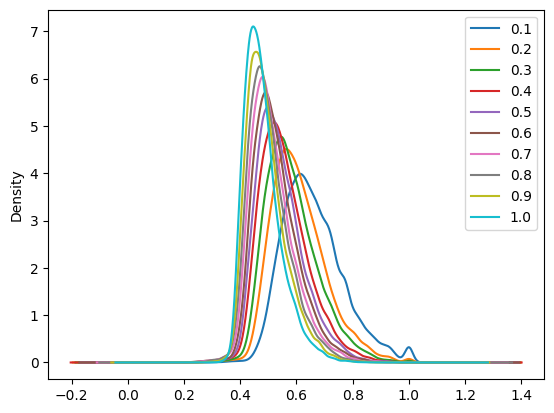

In [19]:
users["history_length"] = users["history"].apply(len)
included_users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()

included_users["activity_percentile"] = pd.qcut(
    included_users.history_length, np.linspace(0, 1, 11), labels=np.arange(1, 11)/10
)

fig, ax = plt.subplots()
for label, df in included_users.groupby("activity_percentile"):
    df.gs.plot(kind="kde", ax=ax, label=label)
plt.legend()
plt.show()